<a href="https://colab.research.google.com/github/Giraud-Pierre/Toxic_Comment_classification/blob/LSTM/Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importation des packages**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from time import time
import numpy as np
import pandas as pd
import tensorflow as tf
import random

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
from drive.MyDrive.NLP_4A.RNN_sentiment_dataset.random_tweets import *

# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split  
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Data Visualization

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

random_tweets imported


# **Importation des données**

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
training_data = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/data_classification_commentaires_toxiques/train.csv')
test_comment = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/data_classification_commentaires_toxiques/test.csv')
test_label = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/data_classification_commentaires_toxiques/test_labels.csv')
training_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


On supprime la colonne id qui est inutile dans cette situation et on récupère les noms des différentes classes.

In [ ]:
training_data = training_data.drop(['id'], axis = 1)
test_data = test_comment.drop(['id'], axis = 1)
test_label = test_label.drop(['id'], axis = 1)

In [ ]:
labels = training_data.drop(['comment_text'],axis = 1).columns
labels

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
for label in labels:
  test_data = test_data.join(test_label[label])

Certaine données du test ont été exclue par l'étude et sont signalé par la valeur -1 dans tous leur libellés. On va donc les retirer des données test.

In [ ]:
test_data = pd.DataFrame(test_data[test_data[labels[0]]!=-1])
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,:Dear god this site is horrible.,0,0,0,0,0,0
11,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


# **Etude des jeux de données**

## Etude des données d'entraînement

On calcule le nombre de commentaires dans chaque catégorie et leur proportion dans le nombre de commentaires totaux

In [ ]:
training_comments_repartition = {'total' : len(training_data)}
for label in labels:
  training_comments_repartition[label] = len(training_data[training_data[label] == 1])
training_comments_repartition

{'total': 159571,
 'toxic': 15294,
 'severe_toxic': 1595,
 'obscene': 8449,
 'threat': 478,
 'insult': 7877,
 'identity_hate': 1405}

In [ ]:
training_comments_proportion = {}
for label in labels:
  training_comments_proportion[label] = str(round(training_comments_repartition[label]*100 / training_comments_repartition['total'],2)) + "% des commentaires totaux"
training_comments_proportion

{'toxic': '9.58% des commentaires totaux',
 'severe_toxic': '1.0% des commentaires totaux',
 'obscene': '5.29% des commentaires totaux',
 'threat': '0.3% des commentaires totaux',
 'insult': '4.94% des commentaires totaux',
 'identity_hate': '0.88% des commentaires totaux'}

On calcule le nombre de commentaires en commun entre 2 classes et leur proportion dans le nombre de commentaires d'une de ces 2 classes

In [ ]:
two_classes_training_comments_repartition={}
two_classes_training_commments_proportion={}
for label1 in labels:
  two_classes_training_comments_repartition[label1] =  ""   #Pour améliorer la lisibilité, on ajoute une ligne indiquant la catégorie dans laquelle on se trouve
  two_classes_training_commments_proportion[label1] =  ""   #Identique à la ligne ci-dessus
  for label2 in labels:
    if(label1 != label2):
      two_classes_training_comments_repartition[label1 + " and " + label2] = len(training_data[(training_data[label1] == 1) & (training_data[label2] == 1)])
      two_classes_training_commments_proportion[label1 + " and " + label2] = (
                                        str(round(two_classes_training_comments_repartition[label1 + " and " + label2] * 100 / training_comments_repartition[label1],2)) 
                                        + "% des commentaires " 
                                        + label1)
two_classes_training_comments_repartition

{'toxic': '',
 'toxic and severe_toxic': 1595,
 'toxic and obscene': 7926,
 'toxic and threat': 449,
 'toxic and insult': 7344,
 'toxic and identity_hate': 1302,
 'severe_toxic': '',
 'severe_toxic and toxic': 1595,
 'severe_toxic and obscene': 1517,
 'severe_toxic and threat': 112,
 'severe_toxic and insult': 1371,
 'severe_toxic and identity_hate': 313,
 'obscene': '',
 'obscene and toxic': 7926,
 'obscene and severe_toxic': 1517,
 'obscene and threat': 301,
 'obscene and insult': 6155,
 'obscene and identity_hate': 1032,
 'threat': '',
 'threat and toxic': 449,
 'threat and severe_toxic': 112,
 'threat and obscene': 301,
 'threat and insult': 307,
 'threat and identity_hate': 98,
 'insult': '',
 'insult and toxic': 7344,
 'insult and severe_toxic': 1371,
 'insult and obscene': 6155,
 'insult and threat': 307,
 'insult and identity_hate': 1160,
 'identity_hate': '',
 'identity_hate and toxic': 1302,
 'identity_hate and severe_toxic': 313,
 'identity_hate and obscene': 1032,
 'identit

In [ ]:
two_classes_training_commments_proportion

{'toxic': '',
 'toxic and severe_toxic': '10.43% des commentaires toxic',
 'toxic and obscene': '51.82% des commentaires toxic',
 'toxic and threat': '2.94% des commentaires toxic',
 'toxic and insult': '48.02% des commentaires toxic',
 'toxic and identity_hate': '8.51% des commentaires toxic',
 'severe_toxic': '',
 'severe_toxic and toxic': '100.0% des commentaires severe_toxic',
 'severe_toxic and obscene': '95.11% des commentaires severe_toxic',
 'severe_toxic and threat': '7.02% des commentaires severe_toxic',
 'severe_toxic and insult': '85.96% des commentaires severe_toxic',
 'severe_toxic and identity_hate': '19.62% des commentaires severe_toxic',
 'obscene': '',
 'obscene and toxic': '93.81% des commentaires obscene',
 'obscene and severe_toxic': '17.95% des commentaires obscene',
 'obscene and threat': '3.56% des commentaires obscene',
 'obscene and insult': '72.85% des commentaires obscene',
 'obscene and identity_hate': '12.21% des commentaires obscene',
 'threat': '',
 'thr

## Etude des données de test

On calcule le nombre de commentaires dans chaque catégorie et leur proportion dans le nombre de commentaires totaux

In [ ]:
test_comments_repartition = {'total' : len(test_data)}
for label in labels:
  test_comments_repartition[label] = len(test_data[test_data[label] == 1])
test_comments_repartition

{'total': 63978,
 'toxic': 6090,
 'severe_toxic': 367,
 'obscene': 3691,
 'threat': 211,
 'insult': 3427,
 'identity_hate': 712}

In [ ]:
test_comments_proportion = {}
for label in labels:
  test_comments_proportion[label] = str(round(test_comments_repartition[label]*100 / test_comments_repartition['total'],2)) + "% des commentaires totaux"
test_comments_proportion

{'toxic': '9.52% des commentaires totaux',
 'severe_toxic': '0.57% des commentaires totaux',
 'obscene': '5.77% des commentaires totaux',
 'threat': '0.33% des commentaires totaux',
 'insult': '5.36% des commentaires totaux',
 'identity_hate': '1.11% des commentaires totaux'}

On calcule le nombre de commentaires en commun entre 2 classes et leur proportion dans le nombre de commentaires d'une de ces 2 classes

In [ ]:
two_classes_test_comments_repartition={}
two_classes_test_commments_proportion={}
for label1 in labels:
  two_classes_test_comments_repartition[label1] =  ""   #Pour améliorer la lisibilité, on ajoute une ligne indiquant la catégorie dans laquelle on se trouve
  two_classes_test_commments_proportion[label1] =  ""   #Identique à la ligne ci-dessus
  for label2 in labels:
    if(label1 != label2):
      two_classes_test_comments_repartition[label1 + " and " + label2] = len(test_data[(test_data[label1] == 1) & (test_data[label2] == 1)])
      two_classes_test_commments_proportion[label1 + " and " + label2] = (
                                        str(round(two_classes_test_comments_repartition[label1 + " and " + label2] * 100 / test_comments_repartition[label1],2)) 
                                        + "% des commentaires " 
                                        + label1)
two_classes_test_comments_repartition

{'toxic': '',
 'toxic and severe_toxic': 367,
 'toxic and obscene': 3626,
 'toxic and threat': 205,
 'toxic and insult': 3342,
 'toxic and identity_hate': 693,
 'severe_toxic': '',
 'severe_toxic and toxic': 367,
 'severe_toxic and obscene': 363,
 'severe_toxic and threat': 46,
 'severe_toxic and insult': 330,
 'severe_toxic and identity_hate': 135,
 'obscene': '',
 'obscene and toxic': 3626,
 'obscene and severe_toxic': 363,
 'obscene and threat': 138,
 'obscene and insult': 2729,
 'obscene and identity_hate': 538,
 'threat': '',
 'threat and toxic': 205,
 'threat and severe_toxic': 46,
 'threat and obscene': 138,
 'threat and insult': 138,
 'threat and identity_hate': 47,
 'insult': '',
 'insult and toxic': 3342,
 'insult and severe_toxic': 330,
 'insult and obscene': 2729,
 'insult and threat': 138,
 'insult and identity_hate': 602,
 'identity_hate': '',
 'identity_hate and toxic': 693,
 'identity_hate and severe_toxic': 135,
 'identity_hate and obscene': 538,
 'identity_hate and th

In [ ]:
two_classes_test_commments_proportion

{'toxic': '',
 'toxic and severe_toxic': '6.03% des commentaires toxic',
 'toxic and obscene': '59.54% des commentaires toxic',
 'toxic and threat': '3.37% des commentaires toxic',
 'toxic and insult': '54.88% des commentaires toxic',
 'toxic and identity_hate': '11.38% des commentaires toxic',
 'severe_toxic': '',
 'severe_toxic and toxic': '100.0% des commentaires severe_toxic',
 'severe_toxic and obscene': '98.91% des commentaires severe_toxic',
 'severe_toxic and threat': '12.53% des commentaires severe_toxic',
 'severe_toxic and insult': '89.92% des commentaires severe_toxic',
 'severe_toxic and identity_hate': '36.78% des commentaires severe_toxic',
 'obscene': '',
 'obscene and toxic': '98.24% des commentaires obscene',
 'obscene and severe_toxic': '9.83% des commentaires obscene',
 'obscene and threat': '3.74% des commentaires obscene',
 'obscene and insult': '73.94% des commentaires obscene',
 'obscene and identity_hate': '14.58% des commentaires obscene',
 'threat': '',
 'thr

# **Préparation des données**

On va modifier les données pour enlever les abbréviations, les signes de ponctuations, les contractions de mots (fréquentes en anglais) pour faciliter le travail du réseau de neurone

## Définition de la fonction prepare_string(tweet) pour nettoyer les commentaires

On crée une fonction qui va remplacer les contractions par leur formes complètes et abbréviations par leur significations

In [ ]:
tokenizer = TweetTokenizer(strip_handles=True)
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
corpus = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean(tweet): 
            
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)  
    
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"yrs", "years", tweet)
    tweet = re.sub(r"hrs", "hours", tweet)
    tweet = re.sub(r"2morow|2moro", "tomorrow", tweet)
    tweet = re.sub(r"2day", "today", tweet)
    tweet = re.sub(r"4got|4gotten", "forget", tweet)
    tweet = re.sub(r"b-day|bday", "b-day", tweet)
    tweet = re.sub(r"mother's", "mother", tweet)
    tweet = re.sub(r"mom's", "mom", tweet)
    tweet = re.sub(r"dad's", "dad", tweet)
    tweet = re.sub(r"hahah|hahaha|hahahaha", "haha", tweet)
    tweet = re.sub(r"lmao|lolz|rofl", "lol", tweet)
    tweet = re.sub(r"thanx|thnx", "thanks", tweet)
    tweet = re.sub(r"goood", "good", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    tweet = re.sub(r"some1", "someone", tweet)
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    # Urls
    tweet = re.sub(r"http\S+", "", tweet)
    # Numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Eliminating the mentions
    tweet = re.sub("(@[A-Za-z0-9_]+)","", tweet)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        tweet = tweet.replace(p, '')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')
        
    # Tokenize
    tweet_words = tokenizer.tokenize(tweet)
    
    # Eliminating the word if its length is less than 3
    tweet = [w for w in tweet_words if len(w)>2]
    
    # remove stopwords
    tweet = [w.lower() for w in tweet if not w in stop_words]  
    
    corpus.append(tweet)
    
    # join back
    tweet = ' '.join(tweet)
        
        
    return tweet

In [ ]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(tweet):
    t=[]
    words=tweet.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [ ]:
def prepare_string(tweet):
  tweet = clean(tweet)
  tweet = convert_abbrev_in_text(tweet)
  return tweet

## nettoyage des commentaires

On utilise la fonction prepare_strings pour enlever les contractions et les abbréviations et on enlève les commentaires vides

In [ ]:
%%time
# Apply prepare_string to all rows in 'tweets' column
training_data['comment_text'] = training_data['comment_text'].apply(lambda s : prepare_string(s))
test_data['comment_text'] = test_data['comment_text'].apply(lambda s : prepare_string(s))

# Drop empty values from dataframe
training_data['comment_text'].replace('', np.nan, inplace=True)
training_data.dropna(subset=['comment_text'], inplace=True)

test_data['comment_text'].replace('', np.nan, inplace=True)
test_data.dropna(subset=['comment_text'], inplace=True)

CPU times: user 3min 6s, sys: 1.36 s, total: 3min 7s
Wall time: 3min 42s


L'opération précédente prenant un certain temps (quelques minutes), on sauvegarde les résultates précédents afin de pouvoir les recharger lors d'une session ultérieur sans refaire les étapes précédantes

In [ ]:
training_data.to_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_test.csv', index=False)

## Chargement des données une fois traitées

Une fois les étapes précédentes réalisé une fois, on peut directement recharger les données directement dans leur fichier de sauvegarde et passer à la suite

In [3]:
training_data = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/NLP_4A/Projet/cleaned_test.csv')
training_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation why edits made username hardcore m...,0,0,0,0,0,0
1,daww matches background colour seemingly stuck...,0,0,0,0,0,0
2,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,more cannot make real suggestions improvement ...,0,0,0,0,0,0
4,you sir hero any chance remember page,0,0,0,0,0,0


In [4]:
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,thank understanding think highly would revert ...,0,0,0,0,0,0
1,dear god site horrible,0,0,0,0,0,0
2,somebody invariably try add religion really yo...,0,0,0,0,0,0
3,says right type the type institution needed ca...,0,0,0,0,0,0
4,before adding new product list make sure relev...,0,0,0,0,0,0


# **Etude de différents Modèles**

## RandomForest

On rencontre un problème pour réaliser un RandomForest sur google colabe: la quantité de données nous fait dépasse la RAM maximale allouée par google colab. Pour résoudre ce problème on va enlever une grosse partie des données tout en gardant les commentaires 'severe_toxic', 'threat' et 'identity_hate' car ils sont déjà peu nombreux et on risquerai de ne plus en avoir assez pour que le modèle soit significatif pour ces classes en particulier. Cela change la proportion de commentaire toxique, mais cela ne devrait pas changer signifcativement le résultat du modèle

In [5]:
sample_size = int(25000)

#On sépare les données à garder des données à retirer puis on retire 
#le nombre de données suffisant pour atteindre la taille de sample voulue
data_to_keep= training_data[(training_data['severe_toxic'] == 1) | (training_data['threat'] == 1) | (training_data['identity_hate'] == 1)]
data_to_remove_from = training_data[(training_data['severe_toxic'] == 0) & (training_data['threat'] == 0) & (training_data['identity_hate'] == 0)].head(sample_size - len(data_to_keep))

#On réunit les 2 parties précédentes en mélangeant pour ne peut causer de biais
#à cause des indices des lignes (sinon tous les commentaires 'severe_toxic', 
#'threat' et 'identity_hate' seraient au début et les autres à la fin)
training_sample = data_to_keep.append(data_to_remove_from, ignore_index=True).sample(frac=1).reset_index(drop=True)

On fait ensuite la même chose avec les données de test (encore une fois pour ne pas dépasser la RAM allouée par google Colab)

In [6]:
#On sépare les données à garder des données à retirer puis on retire 
#le nombre de données suffisant pour atteindre la taille de sample voulue
data_to_keep= test_data[(test_data['severe_toxic'] == 1) | (test_data['threat'] == 1) | (test_data['identity_hate'] == 1)]
data_to_remove_from = test_data[(test_data['severe_toxic'] == 0) & (test_data['threat'] == 0) & (test_data['identity_hate'] == 0)].head(sample_size - len(data_to_keep))

#On réunit les 2 parties précédentes en mélangeant pour ne peut causer de biais
#à cause des indices des lignes (sinon tous les commentaires 'severe_toxic', 
#'threat' et 'identity_hate' seraient au début et les autres à la fin)
test_sample = data_to_keep.append(data_to_remove_from, ignore_index=True).sample(frac=1).reset_index(drop=True)

On sépare ensuite les données des classes pour les données d'entraînement et les données de test en prévision pour le random forest

In [7]:
training_data_sample = [*training_sample['comment_text']]
training_labels_sample = [*training_sample.drop(['comment_text'],axis=1).values]
#On prend un échantillon pour les tests 10 fois plus petit que celui pour l'entraînement
test_data_sample = [*test_sample['comment_text']][:int(sample_size/10)]
test_labels_sample = [*test_sample.drop(['comment_text'],axis=1).values][:int(sample_size/10)]

On crée le vecteur tfID des données d'entraînement et de test

In [8]:
Data_temp = training_data_sample.copy()
Data_temp.extend(test_data_sample)
tfIdfVectorizer = TfidfVectorizer()
Data_tfID = tfIdfVectorizer.fit_transform(Data_temp).toarray()

training_data_tfID = Data_tfID[:sample_size]
test_data_tfID= Data_tfID[sample_size:]

In [9]:
#inutile si on les valeurs tests prévu dans le fichier test

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=3, stratify = y)

On n'utilise que 15 estimateurs pour ne pas utiliser
trop de RAM

In [10]:
text_classifier = RandomForestClassifier(n_estimators=15, random_state=0)  

On entraîne le modèle

In [18]:
text_classifier.fit(training_data_tfID, training_labels_sample )

KeyboardInterrupt: ignored

On calcule la prédiction sur les données test Pour pouvoir effectuer quelques mesures de performances:
- matrice de confusion ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) ;
- rapport de classification ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)) ;
- précision ([doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)).

In [14]:
predictions = text_classifier.predict(test_data_tfID)

In [15]:
#print(confusion_matrix(y_test,predictions)) 

print(classification_report(test_labels_sample,predictions))  

print(accuracy_score(test_labels_sample, predictions))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       285
           1       0.34      0.57      0.43        40
           2       0.67      0.61      0.64       187
           3       0.38      0.17      0.24        29
           4       0.63      0.58      0.60       167
           5       0.71      0.36      0.48        67

   micro avg       0.65      0.61      0.63       775
   macro avg       0.57      0.51      0.52       775
weighted avg       0.65      0.61      0.62       775
 samples avg       0.07      0.07      0.07       775

0.8744


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LSTM with GloVe

Le RandomForest n'ayant pas donné de résultat satisfaisant, nous allons réaliser un réseau de neurone LSTM qui est plus complexe et devrait obtenir de meilleurs résultats. 

Hyperparamètres:

In [5]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 20        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(training_data)
test_portion=.025

In [6]:
training_labels = [*training_data.drop(['comment_text'],axis=1).values]
test_labels = [*test_data.drop(['comment_text'],axis=1).values]

In [7]:
comments = [*pd.concat([training_data,test_data])['comment_text']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments)

In [8]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

In [9]:
sequences = tokenizer.texts_to_sequences(comments)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
number_of_training_comments = len(training_data)
training_comments = padded[:number_of_training_comments]
test_comments = padded[number_of_training_comments:]

In [11]:
num_epochs = 10

training_padded = np.array(training_comments)
training_labels = np.array(training_labels)
testing_padded = np.array(test_comments)
testing_labels = np.array(test_labels)

In [12]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length))
model.add(LSTM(units=64))
model.add(Dense(6, activation='sigmoid'))

In [13]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
history = model.fit(training_padded, 
                      training_labels, 
                      epochs=num_epochs, 
                      validation_data=(testing_padded, testing_labels),
                      batch_size = 256,
                      verbose=1)
  
print("Training Complete")

Epoch 1/10
624/624 [==============================] - 21s 23ms/step - loss: 0.1249 - accuracy: 0.9871 - val_loss: 0.0787 - val_accuracy: 0.9976
Epoch 2/10
624/624 [==============================] - 15s 25ms/step - loss: 0.0517 - accuracy: 0.9942 - val_loss: 0.0775 - val_accuracy: 0.9976
Epoch 3/10
624/624 [==============================] - 14s 23ms/step - loss: 0.0407 - accuracy: 0.9938 - val_loss: 0.0832 - val_accuracy: 0.9974
Epoch 4/10
624/624 [==============================] - 15s 24ms/step - loss: 0.0339 - accuracy: 0.9911 - val_loss: 0.0995 - val_accuracy: 0.9921
Epoch 5/10
624/624 [==============================] - 15s 24ms/step - loss: 0.0280 - accuracy: 0.9679 - val_loss: 0.1020 - val_accuracy: 0.9576
Epoch 6/10
624/624 [==============================] - 15s 24ms/step - loss: 0.0227 - accuracy: 0.9252 - val_loss: 0.0998 - val_accuracy: 0.9560
Epoch 7/10
624/624 [==============================] - 15s 24ms/step - loss: 0.0182 - accuracy: 0.8801 - val_loss: 0.1115 - val_accuracy:

Sauvegardez votre modèle en utilisant la méthode ``.save()`` en utilisant comme paramètre le path='/content/drive/MyDrive/Twitter_Dataset/model_train.h5'.

In [15]:
model.save('/content/drive/MyDrive/NLP_4A/Projet/Model/lstm_test.h5')

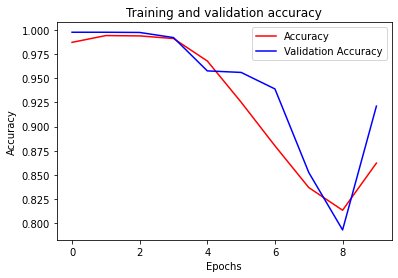

<Figure size 432x288 with 0 Axes>

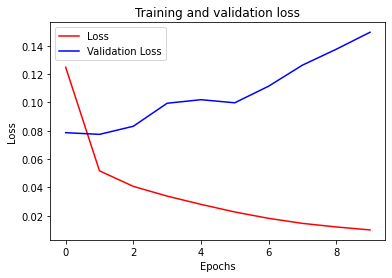

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

# Entraînement du modèle baseline

In [ ]:
# Your Code

# Itération de la modélisation 

In [ ]:
# Your Code 